In [7]:
import numpy as np
import os
import requests
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck18 as cosmo
import matplotlib.cm as mcm
import matplotlib.colors as mcol
import numpy.ma as nma
from sklearn import linear_model
#import fitsio
from astropy.io import fits
from astropy.table import Table
import statmorph

from photutils.background import Background2D, MedianBackground
from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.segmentation import detect_threshold, detect_sources, SourceFinder, SourceCatalog
from photutils.utils import circular_footprint
from astropy.convolution import convolve


plt.style.use('./presentation.mplstyle')

In [3]:
sources = pd.read_csv('v1saga_dwarfs.csv')
print(np.shape(sources))
#download_cutout(sources)

(6337, 26)


In [17]:
channels = {'NUV':mcm.cividis,'FUV':mcm.viridis}

def image_plot(ax,img,cmp):
    m, s = np.mean(img), np.std(img)
    ax.imshow(img, interpolation='nearest', cmap=cmp, vmin=m-s, vmax=m+s, origin='lower')


def download_cutout(sample, size=200,out_dir='GALEX_cutouts/'):
    # will download the files from NERSC into the work_dir folder

    for j in range(len(sample)):
        ra,dec = sample[j,0],sample[j,1]
        filename = 'cutout_{:.4f}_{:.4f}.fits'.format(ra,dec)
        url = ('https://www.legacysurvey.org/viewer/fits-cutout?ra={:.4f}&dec={:.4f}&size='+str(size)+'&layer=galex&pixscale=1.5').format(ra,dec)

        request_apply(url,filename,out_dir) 


def image_bkg(img_dat):
    img_sub = np.zeros((2,200,200))
    img_rms = np.zeros((2,200,200))
    glob_rms = np.zeros(2)

    img_arr = img_dat[0].data
    img_hdr = img_dat[0].header

    w = wcs.WCS(img_hdr,naxis=2)

    flags=[False]*2 

    fig,ax=plt.subplots(2,2,figsize=(12,14),sharey=True)
   
    for i,key in enumerate(channels):        
        threshold = detect_threshold(img_arr[i,:,:], nsigma=1.0)
        segment_img = detect_sources(img_arr[i,:,:], threshold, npixels=10,connectivity=4)

        try: mask = segment_img.make_source_mask(size=2)
        except: 
            flags[i]=True
            continue

        image_plot(ax[0,i],nma.masked_array(img_arr[i,:,:],mask=mask),channels[key])
        
        bkg = Background2D(img_arr[i,:,:].astype(img_arr[i,:,:].dtype.newbyteorder('=')), ( 32, 32), filter_size=(5,5), mask=mask)

        print(key+' Background:',bkg.background_median,key+' RMS^2:',np.square(bkg.background_rms_median))

        img_sub[i] = img_arr[i,:,:]-np.abs(bkg.background)
        #img_rms[i] = np.sqrt(var)
        glob_rms[i] = bkg.background_median

        image_plot(ax[1,i],img_sub[i],channels[key])


    #plt.subplots_adjust(wspace=0.0,hspace=0.05)
    plt.show()

    return img_sub, img_hdr, img_rms, 

3950 [219.65785     2.5396734] 0.09765 9.636
https://www.legacysurvey.org/viewer/fits-cutout?ra=219.6578&dec=2.5397&size=200&layer=galex&pixscale=1.5
downloading --  cutout_219.6578_2.5397.fits
NUV Background: -1.2760449e-05 NUV RMS^2: 5.407382e-07
FUV Background: -8.806359e-05 FUV RMS^2: 6.691123e-08


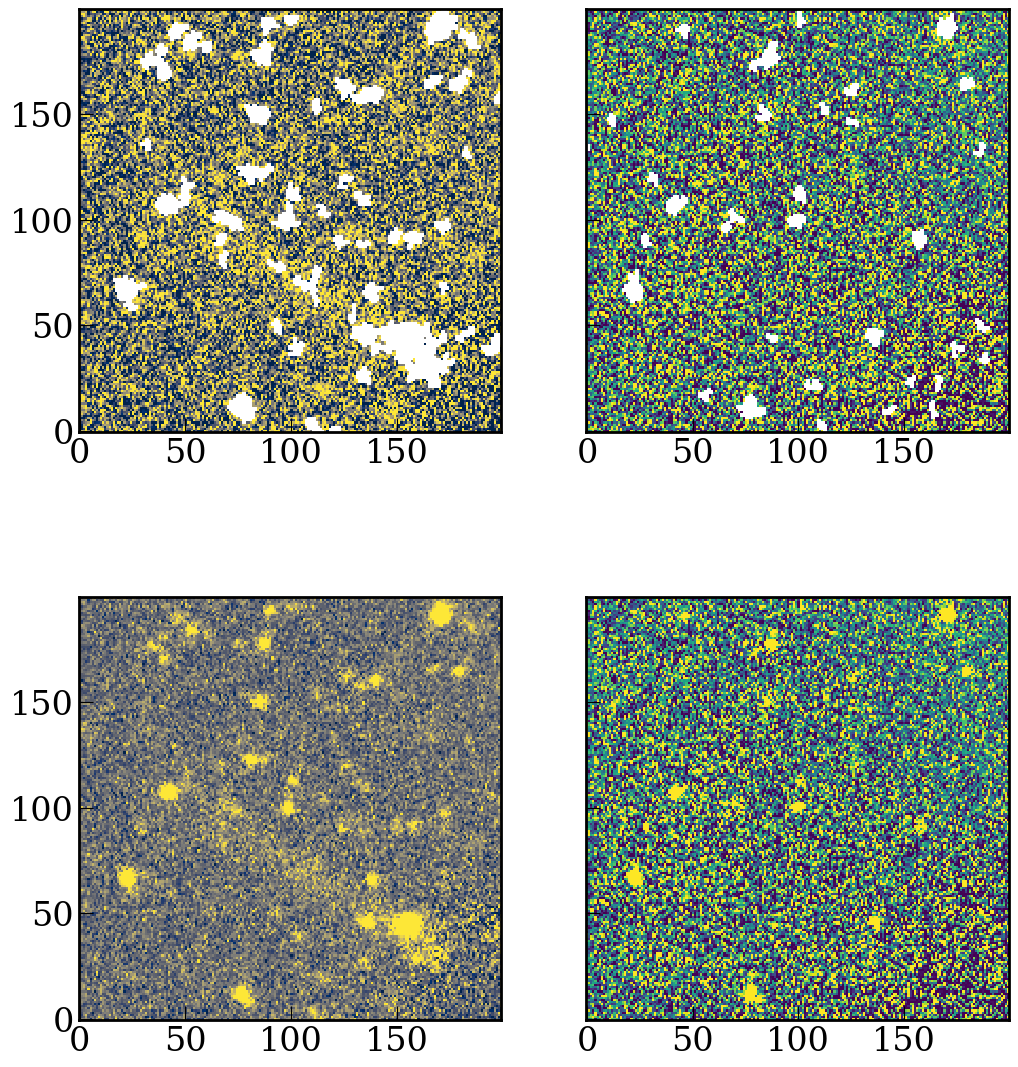

5573 [329.262841  -44.1637457] 0.09027 8.706
https://www.legacysurvey.org/viewer/fits-cutout?ra=329.2628&dec=-44.1637&size=200&layer=galex&pixscale=1.5
downloading --  cutout_329.2628_-44.1637.fits
NUV Background: -0.0006973545 NUV RMS^2: 4.6565474e-06


ValueError: All boxes contain <= 921.6 unmasked or finite pixels (self.box_size=array([32, 32]), self.exclude_percentile=10.0). Please check your data or increase "exclude_percentile" to allow more boxes to be included.

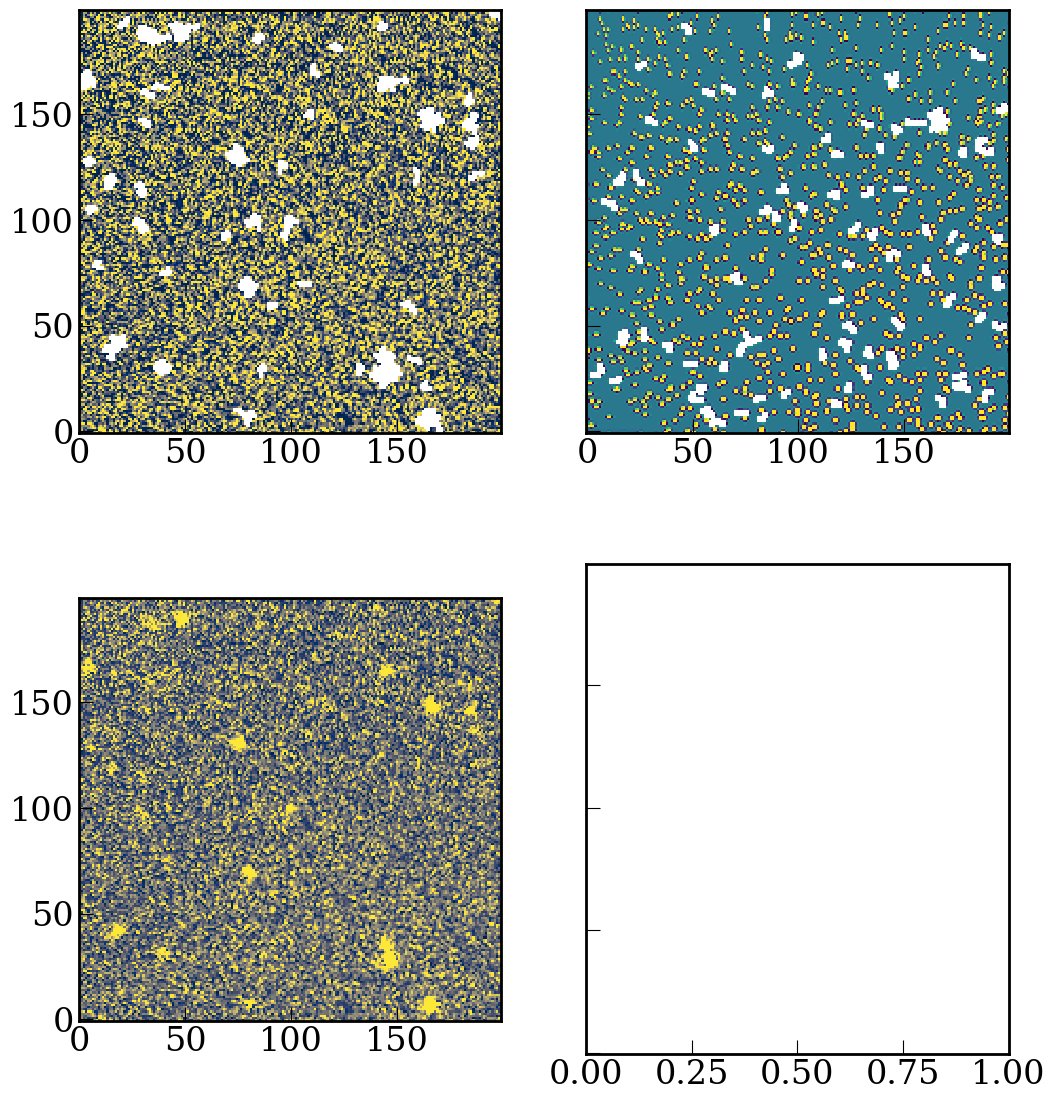

In [20]:

random_sources = sources.sample(n=10)
for ii, key in random_sources.iterrows():
        pos = np.array([key['ra'],key['dec']])
        print(ii,pos,key['zspec'],key['logM'])
        pos_coord = SkyCoord(ra=pos[0]*u.degree, dec=pos[1]*u.degree, frame='icrs')
        
        download_cutout(pos.reshape(1,2))

        filename = 'cutout_{:.4f}_{:.4f}.fits'.format(pos[0],pos[1])
        #print(filename)
        try: data = fits.open("GALEX_cutouts/"+filename)
        except: continue

        img_data,img_hdr,img_rms = image_bkg(data)

        w = wcs.WCS(img_hdr,naxis=2)
        wc = [int(i) for i in w.world_to_pixel(pos_coord)]
        

In [13]:
sources = pd.read_csv('v1saga_dwarfs.csv')
print(np.shape(sources))
#download_cutout(sources)

matches = pd.read_csv('MAST_Crossmatch_GALEX.csv')
filt_matches = matches[matches['nuv_mag'] > 0]
galex = filt_matches.drop_duplicates(subset=['Target'])



(5167, 18)
      Target          RA        DEC              MatchID     MatchRA  \
0       2122   32.783713 -32.578139  6385200682496955053   32.782969   
1      33051  206.210211  41.581573  3869333288452621294  206.210518   
2       2771   20.686888  12.723509  6479310009800858877   20.686488   
3      44284  219.133309   2.503569  2933569728178816593  219.133580   
4       1061  321.426733 -45.809833  6383652580864561698  321.426951   
...      ...         ...        ...                  ...         ...   
8185     188    8.502032 -64.251556  6384884013486573929    8.501817   
8186   32754  197.708951  -7.810343  6379008172881873749  197.709209   
8189   14926   53.566911 -13.856881  6377319397109795016   53.566614   
8195   34883  208.094079  33.130721  6379289663962615277  208.094302   
8203   28686  182.408984  20.075471  6378867522366603867  182.409163   

       MatchDEC  dstArcSec survey  fov_radius                 IAUName  ...  \
0    -32.577883   2.439232    AIS    0.540696 

In [47]:
itsct, gal_ind, src_ind = np.intersect1d(galex['Target'].values,(sources['SI.'].astype(int)).values,return_indices=True)

def sfr_nuv(m_nuv,dist): return 8.875644e-24*np.power(10,m_nuv)/np.square(dist)

dist = (cosmo.comoving_distance(sources['zspec'].iloc[src_ind])).value
m_nuv = galex['nuv_mag'].iloc[gal_ind].to_numpy()


sfr = np.log10(sfr_nuv(m_nuv,dist))
mst = (sources['logM'].iloc[src_ind]).to_numpy()

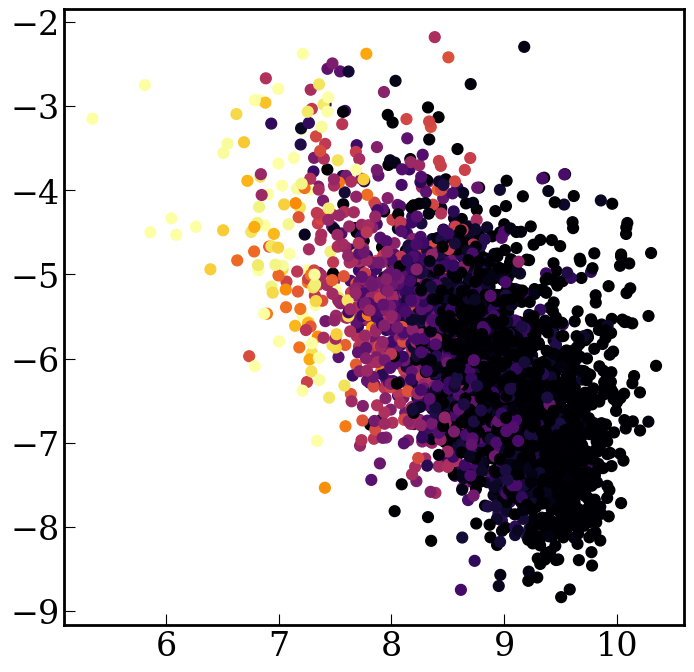

In [51]:
fig,ax=plt.subplots(figsize=(8,8))

ax.scatter(mst,sfr,c=np.log10(dist),s=60,cmap=mcm.inferno_r,vmin=1.5,vmax=2.5)


In [23]:
channels = {'g':mcm.cividis,'r':mcm.viridis,'i':mcm.inferno,'z':mcm.Greys_r}
griz_col = ['tab:blue','tab:green','tab:orange','tab:red']
positions = [0, 1, 2, 3]
labels = ['g', 'r', 'i', 'z']

In [4]:
morph_all = np.load('morph_array.npy')

In [56]:
npr = {1:[[0.3,1.0],r'${\it Gini}$'],2:[[-2,-0.5],r'$M_{20}$'],5:[[1.5,4],r'$Concentration$'],6:[[-0.75,0.75],r'$Asymmetry$'],7:[[-0.1,0.1],r'$Smoothness$']}


3291


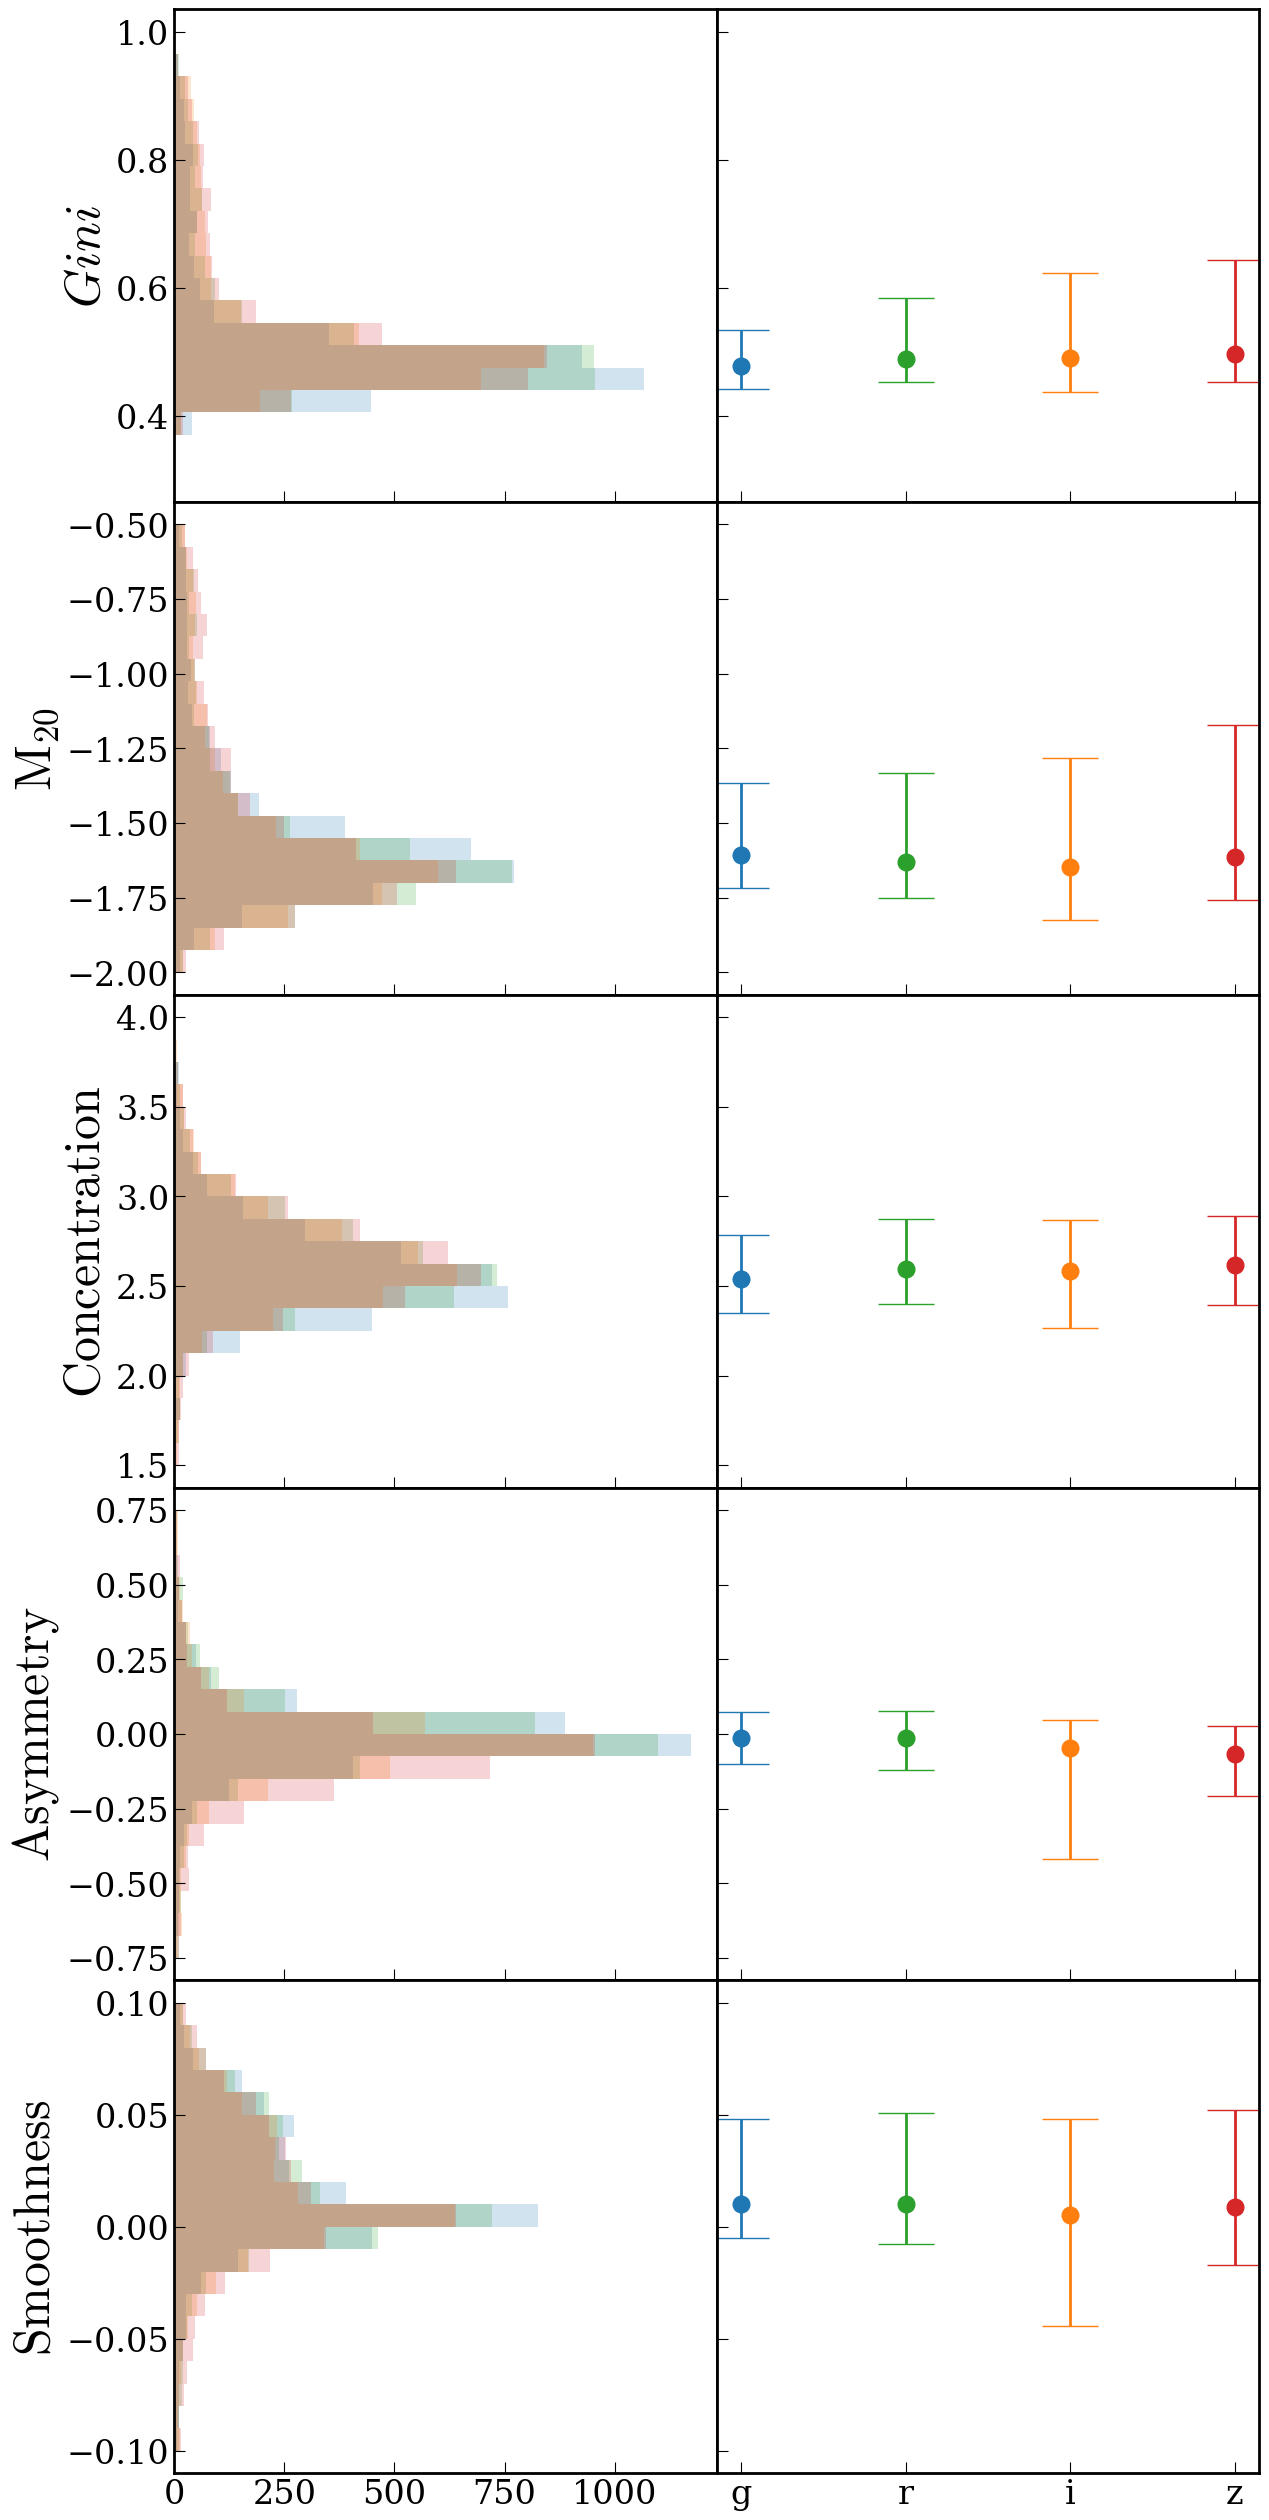

In [45]:
filt_cmap = [mcm.cividis_r,mcm.viridis_r,mcm.inferno_r,mcm.Greys]

high_snr = np.where((morph_all[:,0,10]>1)&(morph_all[:,1,10]>1))[0]
#high_snr = np.where((morph_all[:,0,9]<2)&(morph_all[:,0,9]>1))[0]
print(len(high_snr))


fig,ax=plt.subplots(5,2,figsize=(14,32),sharex='col',sharey='row')

npr = {1:[[0.3,1.0],r'${\it Gini}$'],2:[[-2,-0.5],r'$M_{20}$'],5:[[1.5,4],r'$Concentration$'],6:[[-0.75,0.75],r'$Asymmetry$'],7:[[-0.1,0.1],r'$Smoothness$']}
median_arr = np.zeros((4,5))

for i in range(4):
    #print(morph_arr[:,-1])
    for j,key in enumerate(npr):
        ax[j,0].hist(morph_all[high_snr,i,key],bins=np.linspace(npr[key][0][0],npr[key][0][1],21),alpha=0.2,color=griz_col[i],orientation='horizontal')

        median_arr[i,j] = np.median(morph_all[high_snr,i,key])
        ax[j,1].errorbar(i,median_arr[i,j],yerr=np.array([median_arr[i,j]-np.percentile(morph_all[high_snr,i,key],16),np.percentile(morph_all[high_snr,i,key],84)-median_arr[i,j]]).reshape(2,1),color=griz_col[i],marker='o',markersize=12,elinewidth=2,capsize=20)
    
ax[4,1].xaxis.set_major_locator(ticker.FixedLocator(positions))
ax[4,1].xaxis.set_major_formatter(ticker.FixedFormatter(labels))

ax[0,0].set_ylabel(r'${\it Gini}$',fontsize=36)
ax[1,0].set_ylabel(r'$M_{20}$',fontsize=36)
ax[2,0].set_ylabel(r'$Concentration$',fontsize=36)
ax[3,0].set_ylabel(r'$Asymmetry$',fontsize=36)
ax[4,0].set_ylabel(r'$Smoothness$',fontsize=36)

plt.subplots_adjust(hspace=0.0,wspace=0.0)
plt.savefig('NPdistributions.pdf',bbox_inches='tight')

3293The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
 3293
3293 3293
3293 3293
3293 3293


<>:25: SyntaxWarning: invalid escape sequence '\i'
<>:25: SyntaxWarning: invalid escape sequence '\i'
/var/folders/_b/znph9d951ln009y69l1s4tn00000gn/T/ipykernel_1263/3381499641.py:25: SyntaxWarning: invalid escape sequence '\i'
  ax[0].set_xlabel(r'${\it Gini}$',fontsize=36)


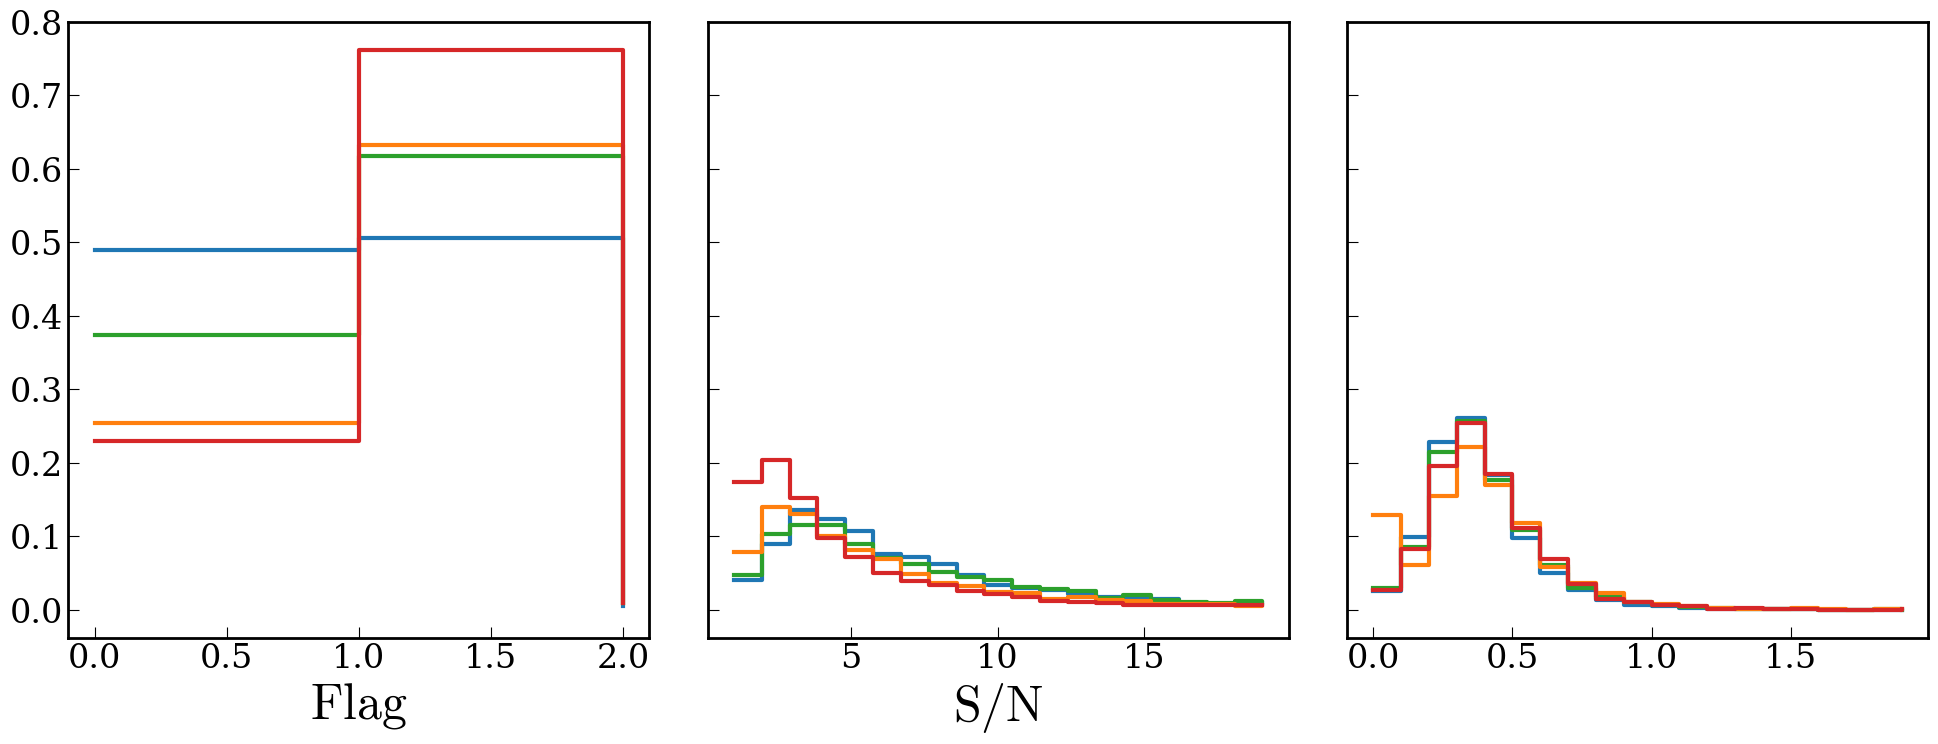

In [30]:
fig,ax=plt.subplots(1,3,figsize=(24,8),sharey='row')

griz_col = ['tab:blue','tab:green','tab:orange','tab:red']

for i in range(4):
    print(len(morph_all[:,i,9]),len(morph_all[:,i,10]))
    #print(morph_arr[:,-1])
    hist, bin_edg = np.histogram(morph_all[:,i,9], bins=np.arange(0,4,1))
    
    ax[0].step(bin_edg[:-1],hist/len(morph_all[:,i,9]),where='post',lw=3,color=griz_col[i])

    hist, bin_edg = np.histogram(morph_all[:,i,10], bins=np.linspace(1,20,21))
    
    ax[1].step(bin_edg[:-1],hist/len(morph_all[:,i,10]),where='post',lw=3,color=griz_col[i])
    #ax[i,2].hist(morph_all[:,i,10],bins=np.linspace(0,1,26),alpha=0.4,color=griz_col[i])

    hist, bin_edg = np.histogram(morph_all[:,i,11], bins=np.linspace(0,2,21))
    
    ax[2].step(bin_edg[:-1],hist/len(morph_all[:,i,11]),where='post',lw=3,color=griz_col[i])

ax[0].set_xlabel(r'${Flag}$',fontsize=36)
ax[1].set_xlabel(r'$S/N$',fontsize=36)
#ax[3,2].set_xlabel(r'$Segm\ Frac$',fontsize=36)
'''
ax[0].set_xlabel(r'${\it Gini}$',fontsize=36)
ax[1].set_xlabel(r'$M_{20}$',fontsize=36)
ax[2].set_xlabel(r'$Concentration$',fontsize=36)
ax[3].set_xlabel(r'$Asymmetry$',fontsize=36)
ax[4].set_xlabel(r'$Smoothness$',fontsize=36)
'''
plt.subplots_adjust(hspace=0.0,wspace=0.1)
#plt.savefig('NPdistributions.pdf',bbox_inches='tight')

[np.float64(0.36953729012259406), np.float64(0.019879876960544822), np.float64(-0.6222492733679056)]
[np.float64(-0.9366910241545428), np.float64(-0.07678226675356456), np.float64(1.0805256079527559)]
[np.float64(1.8154056896515423), np.float64(0.1051696100542282), np.float64(-2.74618030012171)]
[np.float64(-0.09979921239657019), np.float64(0.0027800758313767794), np.float64(-0.6973569485919249)]
[np.float64(0.10321728698228279), np.float64(-0.012522202539264912), np.float64(0.2233819441907656)]
[np.float64(0.38272172887100797), np.float64(0.020213698306656657), np.float64(-0.5639889114492188)]
[np.float64(-0.6855531799390799), np.float64(-0.10503318639696269), np.float64(0.930852580222679)]
[np.float64(1.5448807048988231), np.float64(0.14303111105214966), np.float64(-2.76340650125024)]
[np.float64(-0.8026286466023812), np.float64(0.08472623273190649), np.float64(-1.7212243494874573)]
[np.float64(-0.0632146883005675), np.float64(0.008825827677390014), np.float64(-0.19969252267570956)]


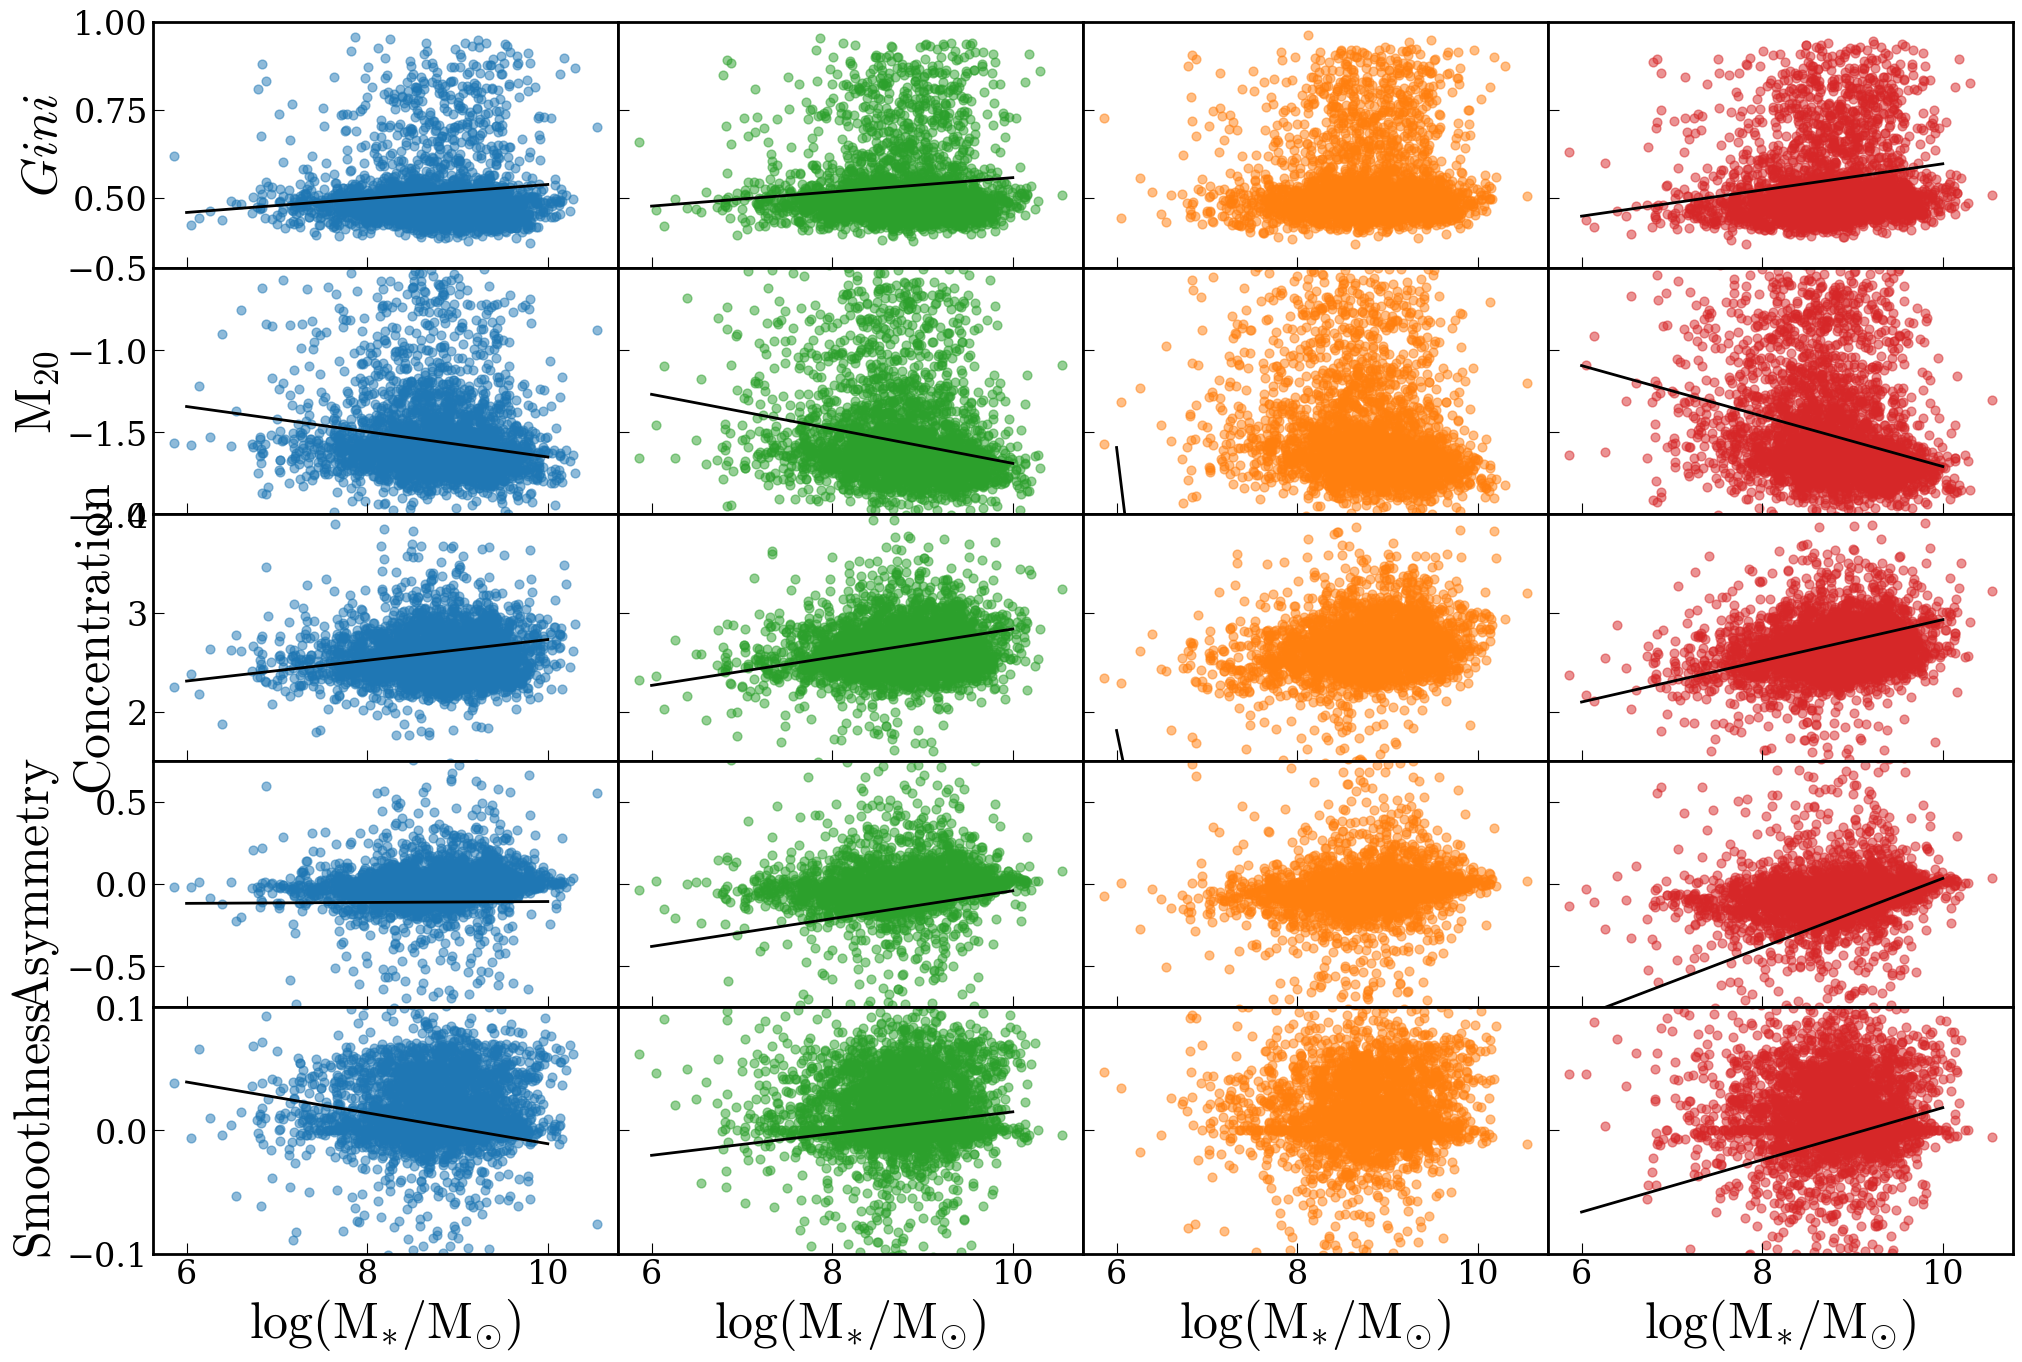

In [63]:
#high_snr = np.where(morph_all[:,0,1]<merger_line(morph_all[:,0,2]))[0]

fig1,ax1=plt.subplots(5,4,figsize=(24,16),sharey='row',sharex='col')

mst = sources['logM'].iloc[morph_all[high_snr,i,0]]
mst_arr = np.linspace(6,10,21)

zspec = sources['zspec'].iloc[morph_all[high_snr,i,0]]
zsp_arr = np.linspace(0,0.1,21)

def linear(X,A):     return A[0]+A[1]*X[0]+A[2]*X[1]
reg = linear_model.LinearRegression()

for i in range(4):
    #high_snr = np.where(morph_all[:,i,1]>merger_line(morph_all[:,i,2]))[0]

    #sersic = sources['reffr'].iloc[morph_all[high_snr,i,0]]
    for j,key in enumerate(npr):
        ax1[j,i].scatter(mst,morph_all[high_snr,i,key],alpha=0.5,color=griz_col[i],s=40)
        ax1[j,i].set_ylim((npr[key][0][0],npr[key][0][1]))


        reg.fit(np.column_stack((mst,zspec)), morph_all[high_snr,i,key])
        p1=[reg.intercept_,*reg.coef_]
        print(p1)

        ax1[j,i].plot(mst_arr,linear([mst_arr,0.05],p1),lw=2,color='black')



    ax1[4,i].set_xlabel(r'${\rm log}(M_{\ast}/M_{\odot})$',fontsize=36)

ax1[0,0].set_ylabel( r'${\it Gini}$',fontsize=36)
ax1[1,0].set_ylabel(r'$M_{20}$',fontsize=36)
ax1[2,0].set_ylabel(r'$Concentration$',fontsize=36)
ax1[3,0].set_ylabel( r'$Asymmetry$',fontsize=36)
ax1[4,0].set_ylabel(r'$Smoothness$',fontsize=36)

plt.subplots_adjust(wspace=0.0,hspace=0.0)

#plt.savefig('NPdistributions2.pdf',bbox_inches='tight')

In [ ]:
fig,ax=plt.subplots(2,4,figsize=(30,16),sharex='col')

griz_col = ['tab:blue','tab:green','tab:orange','tab:red']

for i in range(4):
    #print(morph_arr[:,-1])
    dst = sources['logD'].iloc[morph_all[:,i,0]]
    
    ax[0,i].scatter(np.power(10,dst),morph_all[:,i,9],alpha=0.4,color=griz_col[i],s=40)
    ax[1,i].scatter(np.power(10,dst),morph_all[:,i,10],alpha=0.4,color=griz_col[i],s=40)

    ax[1,i].set_xlabel(r'$D\ (Mpc)$',fontsize=36)

fig,ax=plt.subplots(2,4,figsize=(30,16),sharex='col')

griz_col = ['tab:blue','tab:green','tab:orange','tab:red']

for i in range(4):
    #print(morph_arr[:,-1])
    dst = sources['logM'].iloc[morph_all[:,i,0]]
    
    ax[0,i].scatter(dst,morph_all[:,i,9],alpha=0.4,color=griz_col[i],s=40)
    ax[1,i].scatter(dst,morph_all[:,i,10],alpha=0.4,color=griz_col[i],s=40)

    ax[1,i].set_xlabel(r'${\rm log}(M/M_{\odot})$',fontsize=36)


In [ ]:
kronrad, krflag = sep.kron_radius(data, x, y, a, b, theta, 6.0)
flux, fluxerr, flag = sep.sum_ellipse(data, x, y, a, b, theta, 2.5*kronrad,subpix=1)

flag |= krflag

seg_id = np.arange(1, len(objs)+1, dtype=np.int32)

r, flag = sep.flux_radius(data, objs['x'], objs['y'], 6.*objs['a'],
                          0.5, seg_id=seg_id, seg=seg,
                          normflux=flux, subpix=5)

In [ ]:
from scipy.interpolate import RectBivariateSpline as RBS

def get_star_psf(ns_pos):
        ns_coord = SkyCoord(ra=ns_pos[0]*u.degree, dec=ns_pos[1]*u.degree, frame='icrs')

        download_cutout(ns_pos.reshape(1,2),size=32,out_dir='bright_stars/')
        star_dat = fits.open('bright_stars/cutout_{:.4f}_{:.4f}.fits'.format(ns_pos[0],ns_pos[1]))
        star_arr = star_dat[0].data
        star_hdr = star_dat[0].header

        nw = wcs.WCS(star_hdr,naxis=2)
        nsp2 = [int(i) for i in nw.world_to_pixel(ns_coord)]
        d_psf = 6 # in pixels, the size of the cutout
        
        star_data,star_hdr,star_rms,glob_rms = image_bkg(star_dat[0])
        
        fig,ax=plt.subplots(1,4,figsize=(24,8),sharey='row')
        #fig = plt.figure(figsize=(6*len(c),14)) 
        
        psfs = []
        for jj,ley in enumerate(channels):
            if np.any(star_data[jj]>0):
                #image_plot(ax[ii],star_arr[ii,:,:],channels[key])
            
                objects = sep.extract(star_data[jj], 5, err=star_rms[jj])
                target = np.argmin(np.sqrt((objects['x']-nsp2[0])**2+(objects['y']-nsp2[1])**2))
            
                #ax[ii].scatter(objects['x'][target],objects['y'][target],marker='*',color='red',s=50)
                nsp2[0],nsp2[1] = objects['x'][target],objects['y'][target]
                
                model = star_data[jj][(round(nsp2[1])-d_psf):(round(nsp2[1])+d_psf+1), (round(nsp2[0])-d_psf):(round(nsp2[0])+d_psf+1)]
                model = np.copy(model)
            
                # now we center the psf model via interpolation
                x = np.arange(-d_psf, d_psf+1)
                y = np.arange(-d_psf, d_psf+1)
                model_interp = RBS(y, x, model)
            
                xcen = nsp2[0] - round(nsp2[0])
                ycen = nsp2[1] - round(nsp2[1])
            
                xi = np.arange(xcen-d_psf+1, xcen+d_psf)
                yi = np.arange(ycen-d_psf+1, ycen+d_psf)
            
                model_2 = model_interp(yi, xi)
                model_2 /= np.sum(model_2)
            
                image_plot(ax[jj],model_2,channels[ley])
            
                psfs.append(model_2)


In [ ]:
from sklearn.neighbors import KernelDensity

def hess_arr(x_val,y_val,sky_area,hdex,nbins):
    x_val = (x_val - hdex[0])/(hdex[1]-hdex[0])
    y_val = (y_val - hdex[2])/(hdex[3]-hdex[2])
    dz=1.0/nbins
    
    
    xx,yy=np.meshgrid(np.arange(dz,1+dz,dz),np.arange(dz,1+2*dz,dz))
    xy_sample = np.vstack([yy[:-1].ravel(), xx[:-1].ravel()]).T
    xy_train  = np.vstack([y_val,x_val]).T

    kde_skl = KernelDensity(kernel='gaussian', bandwidth=0.1)
    kde_skl.fit(xy_train)
    hss_est = np.exp(np.reshape(kde_skl.score_samples(xy_sample),(nbins,nbins)))
    #hss_est = hss_est/((hdex[3] - hdex[2])*(hdex[1] - hdex[0]))
    hss_est = hss_est/np.sum(hss_est)
    #hss_est = hss_est/np.amax(hss_est)
    #print(dz*dz*np.sum(hss_est))

    return hss_est

fig1,ax1=plt.subplots(1,4,figsize=(32,10),sharey=True)

hdex = [-2.0,-0.5,0.3,1.0]

M20_arr = np.linspace(-2,-0.5,11)
M20_arrhalf = np.linspace(-2,-1.68,11)


for i in range(4):

    mst = sources['SERSIC'].iloc[morph_all[high_snr,i,0]]
    #dst = np.power(10,sources['logD'].iloc[morph_all[high_snr,i,0]])

    #non_merg = high_snr[np.where(morph_all[high_snr,i,1]<np.minimum(hubble_line(morph_all[high_snr,i,2]),merger_line(morph_all[high_snr,i,2])) )[0]]
    #med_m20,med_gini = np.median(morph_all[non_merg,i,2]),np.median(morph_all[non_merg,i,1])
    #print(med_m20,med_gini)

    hss_arr = hess_arr(morph_all[high_snr,i,2],morph_all[high_snr,i,1],1.0,hdex,80)
    #print(np.sum(hss_arr[j,:,:] ),np.amax(hss_arr[j,:,:] ),np.amin(hss_arr[j,:,:] ))
    ax1[i].imshow(hss_arr,cmap='viridis',aspect='auto',extent = hdex,origin='lower',interpolation='gaussian',norm=mcol.LogNorm(vmax=np.amax(hss_arr),vmin=1e-6))

    #ax1[i].scatter(morph_all[high_snr,i,2]-med_m20,morph_all[high_snr,i,1]-med_gini,c=mst,s=120,cmap=filt_cmap[i],vmin=0.5,vmax=3.5,edgecolors='black')

    #ax1[i].set_ylim((-0.1,0.5))
    #ax1[i].set_xlim((-0.5,1.5))
    ax1[i].plot(M20_arr,merger_line(M20_arr),lw=4,ls='--',color='black')
    ax1[i].plot(M20_arrhalf,hubble_line(M20_arrhalf),lw=4,ls='--',color='black')
    ax1[i].set_xlabel(r'$M_{20}$',fontsize=40)


ax1[0].set_ylabel( r'${\it Gini}$',fontsize=40)